Here we will be implementing a version of CoCa classifier (the current top performer on ImageNet database) by training it on imagenet imstances of our classes and then asking it to classify our 'strange' images.

In [1]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
!pip install -U -q scikeras
!pip install -U -q Pillow
!pip install -U -q tensorflow
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 3.2 MB 11.4 MB/s 
ERROR: Invalid requirement: 'tensorflow#==2.7.0'
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#from google.colab import files

#files.upload(); # upload your kaggle.json file

#import json

#!mkdir /root/.kaggle/
#!mv kaggle.json /root/.kaggle/kaggle.json
#!chmod 600 ~/.kaggle/kaggle.json
#!kaggle config set -n path -v{/content}

In [3]:
#be careful, the data is like 160gb +
#!kaggle competitions download -c imagenet-object-localization-challenge

#CATS AND DOGS
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

#HANDS:
downloaded = drive.CreateFile({'id':'1KcMYcNJgtK1zZvfl_9sTqnyBUTri2aP2'}) 
downloaded.GetContentFile('Hands.zip')

--2022-11-21 11:25:05--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.143.128, 173.194.69.128, 173.194.79.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.143.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  25.4MB/s    in 2.6s    

2022-11-21 11:25:07 (25.4 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [10]:
import os 
import zipfile
#TODO: how i unzip is the only way I can think of this may not be working

cd_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(cd_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

h_zip = 'Hands.zip'
zip_ref = zipfile.ZipFile(h_zip, 'r')
zip_ref.extractall('/tmp/cats_and_dogs_filtered/train')
zip_ref.close()
#!unzip '/tmp/cats_and_dogs_filtered.zip'
#if os.path.exists('cats_and_dogs_filtered/train/hands') == False:
#  os.mkdir('cats_and_dogs_filtered/train/hands')
#!unzip Hands.zip -d 'cats_and_dogs_filtered/train'
#TODO: reduce sie of hands, take maybe 1500 images or smn

!ls

Hands.zip  sample_data


In [5]:
#TODO: wrap all of these in IO.byte stream fucking whatever suck fuck 

In [11]:
#setting up correct directories
import numpy as np
#from image import PIL

#FOR THE MOMENT ALL HANDS AARE IN TRAIN. THIS IS FINE WHATEVER
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

train_hands_dir = os.path.join(train_dir, 'Hands')


# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

#NOTE: atm all hands in train dir so no path here

print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total train hand images:', len(os.listdir(train_hands_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))


total training cat images: 1000
total training dog images: 1000
total train hand images: 11077
total validation cat images: 500
total validation dog images: 500


UnidentifiedImageError: ignored

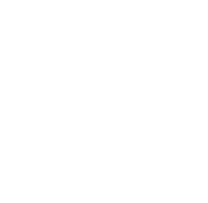

In [14]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in os.listdir(train_cats_dir)[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in os.listdir(train_dogs_dir)[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path) #EVEN HERE IT ERRORS. CANNOT USE PIL IMAGES FORMAT?????
  plt.imshow(img)

plt.show()


In [ ]:
#from glob import glob
#import os

#def clean_directory(dir_path, ext=".jpg"):
#    files = glob(os.path.join(dir_path, ".*" + ext))  # this line find all files witch starts with . and ends with given extension
#    for file_path in files:
#        os.remove(file_path)



In [12]:
#TODO: convert all hand and cat/dog images to same size
import tensorflow
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import PIL
from PIL import Image
import io


# All images will be rescaled by 1./255 for rgb
cdGen = ImageDataGenerator(rescale=1./255)

#WAY STATED IN TUTORIAL TO GET ALL FILES IN

#batch size=all our images
batch_size = len(train_cats_dir) + len(train_dogs_dir) + len(train_hands_dir)

train_generator = cdGen.flow_from_directory(
    directory=train_dir,
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical"
)

num_samples = train_generator.n
num_classes = train_generator.num_classes
input_shape = train_generator.image_shape

classnames = [k for k,v in train_generator.class_indices.items()]

X, y = train_generator.next()
print(X)
#print(y)
#NOTE: NICE. WE SHOULD HAVE THEM ALL RESIZED)

#TODO: THIS IS A PIPELINE ^
#->HAVE TO ACTUALLY EMPLOY IT TO GET THE IMAGES TRANSFORMED, AND STORE EM SOMEWHERE
#IN NP ARRAYS 

#NEED TO ORGANISE SO ITS LIKE:
#->MAIN DIR
#   -> CLASS A
#       ->IMAGES
#   -> CLASS B
#       ->IMAGES
#   ->CLASS C
#       ->IMAGES

#dogs/cats are 500,375
#HANDS are 1600x1200

#ATM these are arrays of directories, can do a loop below to laod all if we want

#img = load_img([PASS ARRAY AND INDEX], target_size=(150, 150))  # this is a PIL image
#x = img_to_array(img)

Found 19076 images belonging to 4 classes.


UnidentifiedImageError: ignored

In [ ]:

#clean_directory(train_cats_dir)
#clean_directory(train_dogs_dir)
#clean_directory(train_hands_dir)

#x = np.array([np.array(Image.open(fname)) for fname in filelist])
cnames = os.listdir(train_cats_dir)
dnames = os.listdir(train_dogs_dir)
hnames = os.listdir(train_hands_dir)

#Doesn't matter what I do. PIL images do not work
cats_train = [os.path.join(train_cats_dir, f) for f in cnames]
hands_train = [os.path.join(train_hands_dir, f) for f in hnames]
dogs_train = [os.path.join(train_dogs_dir, f) for f in dnames]

#LODING IN ARRAYS IN WAY STATED IN TUTORIAL, EVEN THOUGH IT DOESNT WORK
#for p in cats_train:
#  img = load_img(p, target_size=(256, 256))  # this is a PIL image
#  x = img_to_array(img)


#ERROR FOR ALL IMAGES
#for img_p in cnames:
#    try:
#        img = PIL.Image.open(train_cats_dir + "/" + img_p)
#    except PIL.UnidentifiedImageError:
#            print(img_p)


#USE THE ARRAYS ABOVE TO OPEN ALL INTO THEIR FRAMES
#hands = np.array([np.array(Image.open(io.BytesIO(fname))) for fname in hands_train])
#cats = np.array([np.array(Image.open(io.BytesIO(fname))) for fname in cats_train])
#dogs = np.array([np.array(Image.open(io.BytesIO(fname))) for fname in dogs_train])


In [ ]:
#from tensorflow.keras.preprocessing.image import img_to_array, load_img

#cnames = os.listdir(train_cats_dir)
#cvnames = os.listdir(validation_cats_dir)
#dnames = os.listdir(train_dogs_dir)
#dvnames = os.listdir(validation_dogs_dir)
#hnames = os.listdir(train_hands_dir)

#cats_train = [os.path.join(train_cats_dir, f) for f in cnames]
#cats_val = [os.path.join(validation_cats_dir, f) for f in cvnames]
#dogs_train = [os.path.join(train_dogs_dir, f) for f in dnames]
#dogs_val = [os.path.join(validation_dogs_dir, f) for f in dvnames]
#hands_train = [os.path.join(train_hands_dir, f) for f in hnames]

#hands_train = hands[:1000]
#hands_val = hands[1000:1500]

#df_train = {}
#df_val = {}

#df_train['image'] = cats_train
#df_train['class'] = ([0]* len(cats_train))
#df_train['image'].append(dogs_train)
#df_train['class'].append([1]*len(dogs_train))
#df_train['image'].append(hands_train)
#df_train['class'].append([2]*len(hands_train))

#df_val['image'] = cats_val
#df_val['class'] = ([0]* len(cats_val))
#df_val['image'].append(dogs_val)
#df_val['class'].append([1]*len(dogs_val))
#df_val['image'].append(hands_val)
#df_val['class'].append([2]*len(hands_val))

In [ ]:
!pip install coca-pytorch
!pip install vit-pytorch

In [ ]:
#Image preprocessing
#import io

#import torchvision.transforms as T

#from PIL import Image
#resp = #IMAGEFILE
#img = Image.open(io.BytesIO(resp.content))

#preprocess = T.Compose([
#   T.Resize(256),
#   T.CenterCrop(224),
#   T.ToTensor(),
#   T.Normalize(
#       mean=[0.485, 0.456, 0.406],
#       std=[0.229, 0.224, 0.225]
#   )
#])

#x = preprocess(img)
#x.shape
#THIS SHOULD BE ABLE TO CONVERT ANY IMAGE INDIVIDUALLY ^, JUST LOOP FOR ALL OR WHATEVER
#AND, DECIDE WHAT SHAPE IMAGES SHOULD BE ETC, RESIZE MAIN THING

#dog = 
#cat = 
#hands = 

In [ ]:
import torch

# import vision transformer

from vit_pytorch import ViT
from vit_pytorch.extractor import Extractor

vit = ViT(
    image_size = 256,
    patch_size = 32,
    num_classes = 1000,
    dim = 1024,
    depth = 6,
    heads = 16,
    mlp_dim = 2048
)

#TODO: try and get this to work for just cats and dogs
#TODO: pretty sure labels are needed too
vit = Extractor(vit, return_embeddings_only = True, detach = False)

# extractor will enable it so the vision transformer returns its embeddings

# import CoCa and instantiate it

from coca_pytorch.coca_pytorch import CoCa

#FIXED: must enable GPU hardware acceleration in runtime settings or this will not work
coca = CoCa(
    dim = 512,                     # model dimension
    img_encoder = vit,             # vision transformer - image encoder, returning image embeddings as (batch, seq, dim)
    #image_dim = 1024,              # image embedding dimension, if not the same as model dimensions
    num_tokens = 3,            # number of text tokens
    unimodal_depth = 6,            # depth of the unimodal transformer
    multimodal_depth = 6,          # depth of the multimodal transformer
    dim_head = 64,                 # dimension per attention head
    heads = 8,                     # number of attention heads
    caption_loss_weight = 1.,      # weight on the autoregressive caption loss
    contrastive_loss_weight = 1.,  # weight on the contrastive loss between image and text CLS embeddings
).cuda()

#TODO: replace these with imageNet instances

text = torch.from_numpy(train_generator.classes) #.cuda()
images = torch.from_numpy(train_generator) #.cuda()

# train by giving CoCa your text and images with `return_loss = True`

loss = coca(
    text = text,
    images = images
    #return_loss = True  # set this to True to get the full caption + contrastive loss
)

loss.backward()

# TODO ^ train above on imagenet data

logits = coca(
    text = text,
    images = images
) # (4, 512, 20000)

# and the CLIP-like text and image embeddings as

text_embeds, image_embeds = coca(
    text = text,
    images = images,
    return_embeddings = True
) # (4, 512), (4, 512)

CITATIONS/REFERENCES:

@article{afifi201911kHands, 
title = {11K Hands: gender recognition and biometric identification using a large dataset of hand images}, author = {Afifi, Mahmoud}, journal = {Multimedia Tools and Applications}, doi = {10.1007/s11042-019-7424-8}, url = {https://doi.org/10.1007/s11042-019-7424-8}, year={2019} 

@inproceedings{Yu2022CoCaCC,
  title   = {CoCa: Contrastive Captioners are Image-Text Foundation Models},
  author  = {Jiahui Yu and Zirui Wang and Vijay Vasudevan and Legg Yeung and Mojtaba Seyedhosseini and Yonghui Wu},
  year    = {2022}
}}

@Lots of code referenced from:
https://colab.research.google.com/github/google/eng-edu/blob/master/ml/pc/exercises/image_classification_part1.ipynb#scrollTo=TkNQqjZaB4_u